In [2]:
import os
os.chdir('/Users/Olivier/anaconda3/envs/guitarsounds')
%load_ext autoreload

In [4]:
%autoreload 2
from guitarsounds import Sound, Signal
import guitarsounds as guit

In [5]:
import matplotlib.pyplot as plt
import numpy as np

## Import the soundhole testing dataset

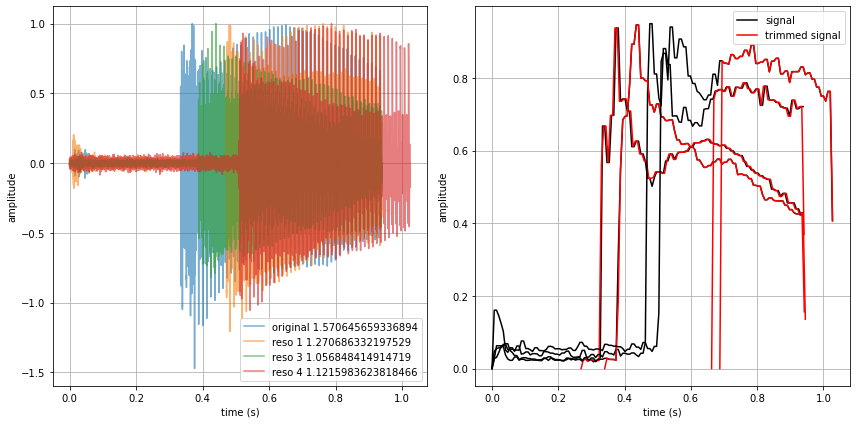

In [44]:
# Filenames
fileOG = 'soundfiles/test_reso/originale.wav_mono2.wav'
fileres1 = 'soundfiles/test_reso/res1.wav_mono2.wav'
fileres3 = 'soundfiles/test_reso/res3.wav_mono2.wav'
fileres4 = 'soundfiles/test_reso/res4.wav_mono2.wav'
files = [fileOG, fileres1, fileres3, fileres4]
names = ['original', 'reso 1', 'reso 3', 'reso 4']
guit.SP.change('frame_size', 300)
guit.SP.change('hop_length', 150)
sounds = []

for file, name in zip(files, names):
    sounds.append(Sound(file, name=name))

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

for sound in sounds:
    plt.sca(ax1)
    sound.raw_signal.normalize().plot('signal', label=sound.name + ' ' + str(sound.raw_signal.normalize().norm_factor))
    sound.trim_signal()
    
    plt.sca(ax2)
    sound.raw_signal.plot('envelop',c='k')
    envelop = sound.trimmed_signal.envelop()
    envelop_time = sound.trimmed_signal.envelop_time()
    offset = np.argmax(sound.raw_signal.signal)
    offset -= sound.trimmed_signal.onset
    time_offset = (1/sound.trimmed_signal.sr)*offset
    envelop_time += time_offset
    plt.plot(envelop_time, envelop, c='r')

    
ax1.legend()
ax1.grid('on')
ax2.legend(['signal', 'trimmed signal'])
ax2.grid('on')
plt.tight_layout()

**Problème quand l'attaque ne correspond pas au maximum du signal**

## Trouver l'onset sans se baser sur le maximum du signal

1. Trouver une mesure de temps approximative pour l'onset

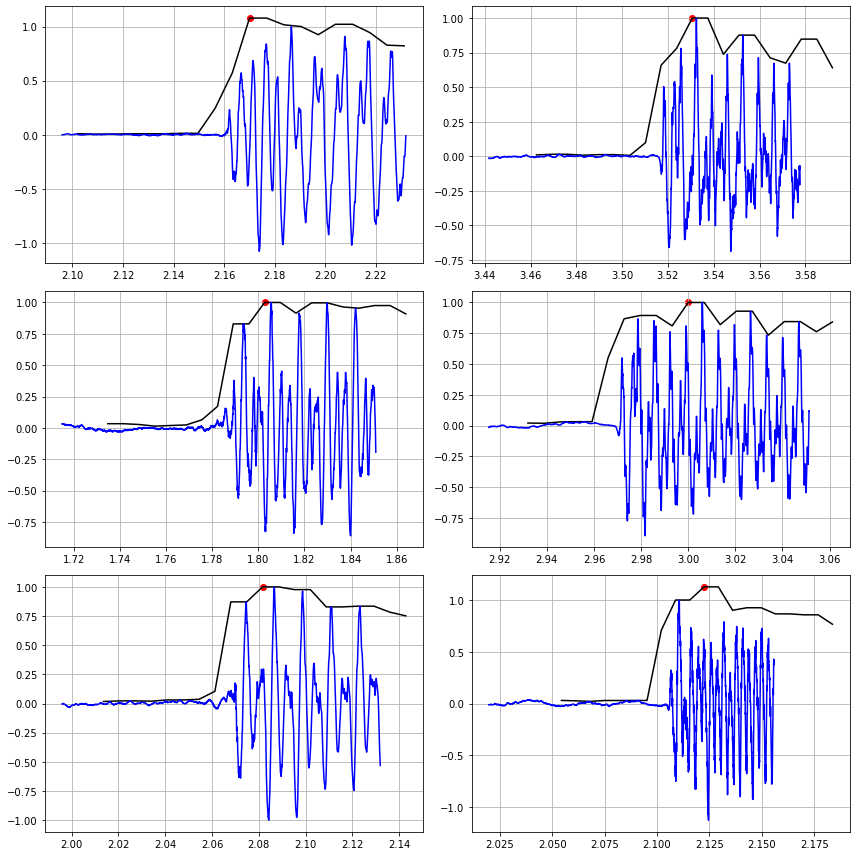

In [10]:
file1 = 'soundfiles/flax_carbon/Wood_A0_1.wav'
file2 = 'soundfiles/flax_carbon/Carbon_D0_2.wav'
file3 = 'soundfiles/flax_carbon/Carbon_E0_1.wav'
file4 = 'soundfiles/flax_carbon/Wood_D0_2.wav'
file5 = 'soundfiles/flax_carbon/Wood_E0_1.wav'
file6 = 'soundfiles/flax_carbon/Wood_E1_1.wav'
files = [file1, file2, file3, file4, file5, file6]

fig, axs = plt.subplots(3,2, figsize=(12,12))
axs = axs.reshape(1, -1)[0]

sounds = [Sound(file) for file in files]
for sound in sounds:
    sound.use_raw_signal()
    
sounds = guit.equalize_time(*sounds)
for sound, ax in zip(sounds, axs):
    onset_index = np.argmax(sound.signal.envelop())
    signal_index = np.argmax(sound.signal.signal)
    dist1 = 10
    dist2 = 10
    d1 = 2000
    d2 = 1000
    
    ax.plot(sound.signal.envelop_time()[onset_index-dist1:onset_index+dist2], sound.signal.envelop()[onset_index-dist1:onset_index+dist2], c='k')
    ax.plot(sound.signal.time()[signal_index-d1:signal_index+d2], sound.signal.signal[signal_index-d1:signal_index+d2], c='b')
    ax.scatter(sound.signal.envelop_time()[onset_index], sound.signal.envelop()[onset_index], c='r')
    ax.grid('on')
plt.tight_layout()
    
    
    
    

**Typiquement l'onset se produit sur une distance de 0.025 s**

2. Détecter l'attaque comme une augmentation de plus de 50% du signal normalisé dans un interval de 0.025s

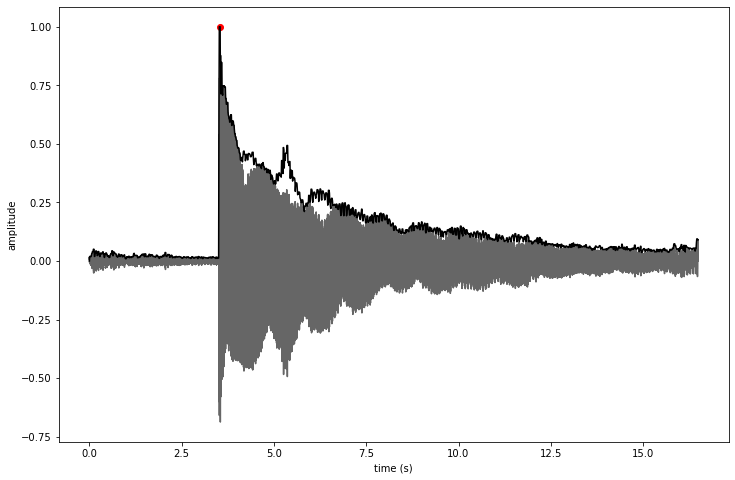

In [22]:
test_sound = Sound('soundfiles/flax_carbon/Carbon_D0_2.wav')
test_sound.use_raw_signal(normalized=True)

# index correspondant à 0.025s
window_index = np.ceil(0.025 * test_sound.signal.sr).astype(int)
overlap = window_index // 2
increase = 0
i = 0
while increase <= 0.5:
    signal_min = np.min(np.abs(test_sound.signal.signal[i:i+window_index]))
    signal_max = np.max(np.abs(test_sound.signal.signal[i:i+window_index]))
    if signal_max>0.5:
        increase = signal_max/signal_min
    else:
        increase = 0
    i += overlap
    if i+window_index > len(test_sound.signal.signal):
        print('Onset detection did not converge \n')
        print('Approximating onset with signal max value')
        break
        
onset = np.argmax(np.abs(test_sound.signal.signal[i:i+window_index]))+i
plt.figure(figsize=(12,8))
test_sound.signal.plot('signal', c='k')
test_sound.signal.plot('envelop', c='k')
plt.scatter(test_sound.signal.time()[onset], np.abs(test_sound.signal.signal[onset]), c='r')
plt.show()

## Implementation

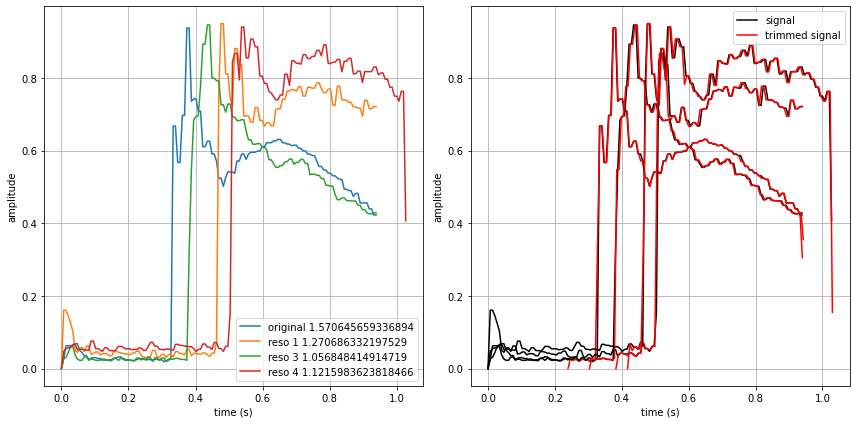

In [23]:
# Filenames
fileOG = 'soundfiles/test_reso/originale.wav_mono2.wav'
fileres1 = 'soundfiles/test_reso/res1.wav_mono2.wav'
fileres3 = 'soundfiles/test_reso/res3.wav_mono2.wav'
fileres4 = 'soundfiles/test_reso/res4.wav_mono2.wav'
files = [fileOG, fileres1, fileres3, fileres4]
names = ['original', 'reso 1', 'reso 3', 'reso 4']
guit.SP.change('frame_size', 300)
guit.SP.change('hop_length', 150)
sounds = []

for file, name in zip(files, names):
    sounds.append(Sound(file, name=name))

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

for sound in sounds:
    plt.sca(ax1)
    sound.raw_signal.plot('envelop', label=sound.name + ' ' + str(sound.raw_signal.normalize().norm_factor))
    sound.trim_signal()
    
    plt.sca(ax2)
    sound.raw_signal.plot('envelop',c='k')
    envelop = sound.trimmed_signal.envelop()
    envelop_time = sound.trimmed_signal.envelop_time()
    offset = np.argmax(sound.raw_signal.signal)
    offset -= sound.trimmed_signal.onset
    time_offset = (1/sound.trimmed_signal.sr)*offset
    envelop_time += time_offset
    plt.plot(envelop_time, envelop, c='r')

    
ax1.legend()
ax1.grid('on')
ax2.legend(['signal', 'trimmed signal'])
ax2.grid('on')
plt.tight_layout()